# Styling Tables

> Styling `DataFrame`s to make them more readable and skannable with heatmaps, bar charts, categorical colors, and plain text.

In [ ]:
#| default_exp style_table

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
#| export
def _category_to_color(categories, colorscale='D3'):
    colorscale = eval(f'px.colors.qualitative.{colorscale}')
    cat_dict = dict(enumerate(set(categories)))
    cat_dict = {v: colorscale[k] for k, v in cat_dict.items()}
    return [cat_dict[cat] for cat in categories]


In [ ]:
#| export
def style_table(
    df,
    column_types,
    column_widths=None,
    title=None,
    precision=1,
    width=None,
    height=None,
    theme='plotly_white',
    font_size=None,
    title_font_size=None):
    """Convert a DataFrame to multiple charts (one for each column).

    Parameters
    ----------
    df : pandas.DataFrame
      Any DataFrame, but typically a small one, to display as a report.
    column_types : list
      A list of types, one for each column. Possible values are "bar", "heatmap", "category", and "text".
    column_widths : list
      A list of fractions that should add up to 1. Each fraction corresponds to a column.
    title : str
      The title of the chart.
    precision : int
      How many decimals of precision to display in numeric columns. This affects all numeric columns.
    width : int
      The width of the entire chart in pixels.
    height : int
      The height of the entire chart in pixels.
    theme : str
      The theme used for styling the entire chart.
    font_size : int
      The size of font of text and number on the chart in points.
    title_font_size : int
      The size of font of the title of the chart in points.
    Returns
    -------
    styled_table : plotly.graph_objects.Figure
      A Plotly Figure object that can be retroactively edited if desired.
    """
    if not set(column_types).issubset(["bar", "heatmap", "category", "text"]):
        raise ValueError("Please make sure you specify any of the following types:\n"
                         "'bar', 'heatmap', 'category', and 'text'")
    fig = make_subplots(
        rows=1,
        cols=df.shape[1],
        column_widths=column_widths,
        horizontal_spacing=0,
        subplot_titles=df.columns)
    categorical_scales = [data.y[0] for data in px.colors.qualitative.swatches().data][::-1]
    categorical_index = 0
    texttemplate = f'%{{text:,.{precision}f}}'
    for i, col in enumerate(df):
        if column_types[i] == 'heatmap':
            fig.add_heatmap(
                z=df[[col]],
                name=col,
                showscale=False,
                colorscale='cividis',
                hovertemplate=texttemplate,
                text=df[[col]],
                texttemplate=texttemplate,
                row=1,
                col=i+1)
        elif column_types[i] == 'bar':
            fig.add_bar(
                x=df[col],
                y=list(range(len(df))),
                showlegend=False,
                orientation='h',
                col=i+1,
                marker={'color': 'steelblue'},
                text=df[col],
                texttemplate=texttemplate,
                hovertemplate=texttemplate,
                row=1,
                name=col)
        elif column_types[i] == 'category':
            categorical_index += 1
            fig.add_bar(
                x=[10 for i in range(len(df))],
                y=list(range(len(df))),
                showlegend=False,
                marker={'color': _category_to_color(
                    df[col],
                    categorical_scales[categorical_index] if df[col].nunique() <= 10 else 'Dark24'),
                        'opacity': 1},
                row=1,
                col=i+1,
                name=col,
                orientation='h',
                text=df[col],
                hovertemplate='<b>%{text}')
        elif column_types[i] == 'text':
            fig.add_bar(
                x=[10 for i in range(len(df))],
                y=list(range(len(df))),
                orientation='h',
                showlegend=False,
                name=col,
                hovertemplate='<b>%{text}',
                marker={'color': 'white'},
                text=df[col],
                texttemplate='%{text}',
                row=1,
                col=i+1)
    fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False)
    fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False, autorange='reversed')
    fig.update_layout(bargap=0, template=theme, width=width, height=height,
                      title=title, font_size=font_size, title_font_size=title_font_size)
    return fig

## Getting started - a simple table

In [ ]:
df = pd.DataFrame({
    'text': ['one', 'two', 'three', 'four', 'five'],
    'category': ['odd', 'even', 'odd', 'even', 'odd'],
    'heatmap': [10, 20, 30, 40, 70],
    'bar': [18, 17, 12, 10, 5]
})

df

text category  heatmap  bar
0    one      odd       10   18
1    two     even       20   17
2  three      odd       30   12
3   four     even       40   10
4   five      odd       70    5

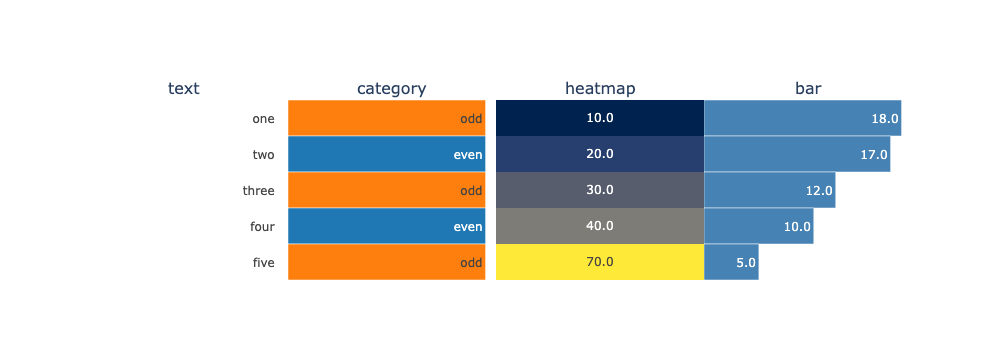

In [ ]:
style_table(
    df,
    column_types=['text', 'category', 'heatmap', 'bar'])

# Modify look and feel

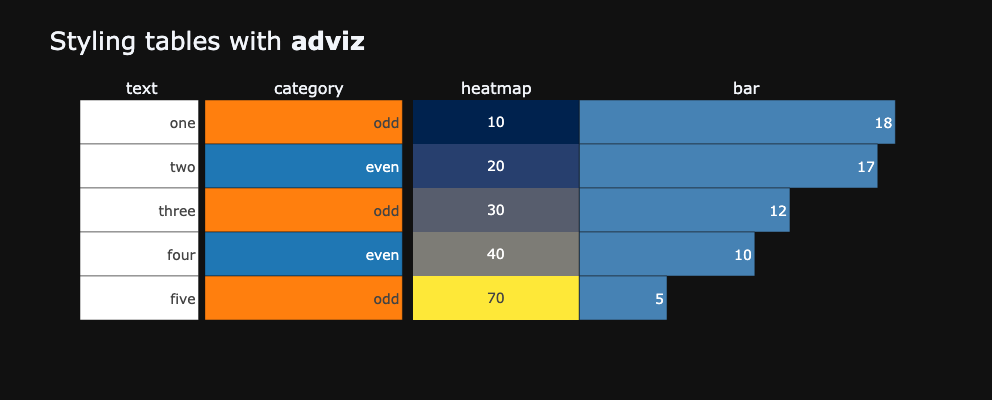

In [ ]:
style_table(
    df,
    column_types=['text', 'category', 'heatmap', 'bar'],
    column_widths=[0.15, 0.25, 0.2, 0.4],
    title='Styling tables with <b>adviz',
    theme='plotly_dark',
    precision=0,
    width=600,
    height=400,
    font_size=14,
    title_font_size=25)

## Styling multiple columns with multiple chart types

First set the categorical order so we can sort medals by rank: bronze < silver < gold.

In [ ]:
medals = px.data.medals_long()[['medal', 'nation', 'count']]
medals['medal'] = (medals['medal']
                   .astype('category')
                   .cat.reorder_categories(['bronze', 'silver', 'gold']))
medals = medals.sort_values(['medal', 'count'], ascending=False)
medals

medal       nation  count
0    gold  South Korea     24
1    gold        China     10
2    gold       Canada      9
4  silver        China     15
3  silver  South Korea     13
5  silver       Canada     12
8  bronze       Canada     12
6  bronze  South Korea     11
7  bronze        China      8

Since each column contains a different type of data, we want to set the types of chart we want ot use to visualize them: 

* medal: category
* nation: category
* count: bar

Note that when you have two categorical columns, different color scales are used to avoid confusion.

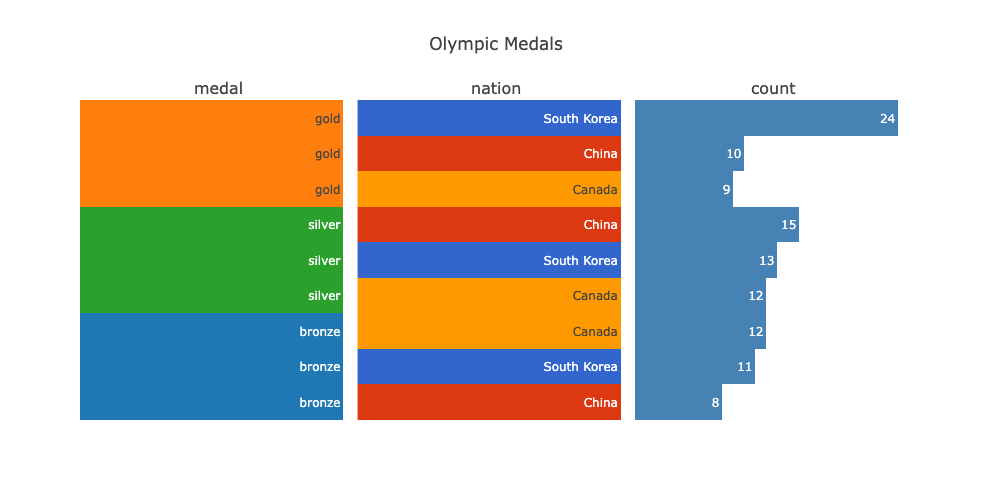

In [ ]:
style_table(
    medals,
    column_types=['category', 'category', 'bar'],
    title='Olympic Medals',
    theme='none',
    precision=0,
    width=800,
    height=500)

You can also use "heatmap" for numeric columns, and it depends on how you want to display it.

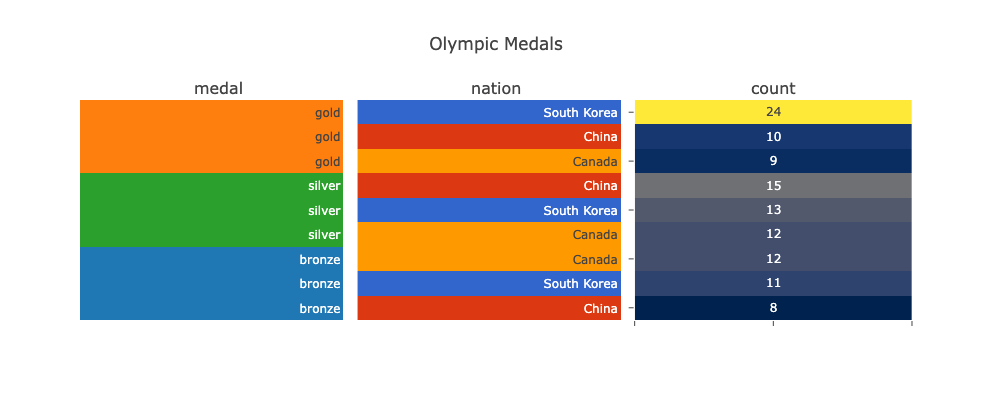

In [ ]:
style_table(
    medals,
    column_types=['category', 'category', 'heatmap'],
    title='Olympic Medals',
    theme='none',
    precision=0,
    width=800,
    height=400)

## Styling many columns with multiple chart types

In [ ]:
election = px.data.election().iloc[:, :-1]
election.head()

district  Coderre  Bergeron  Joly  total    winner     result
0     101-Bois-de-Liesse     2481      1829  3024   7334      Joly  plurality
1  102-Cap-Saint-Jacques     2525      1163  2675   6363      Joly  plurality
2   11-Sault-au-Récollet     3348      2770  2532   8650   Coderre  plurality
3           111-Mile-End     1734      4782  2514   9030  Bergeron   majority
4         112-DeLorimier     1770      5933  3044  10747  Bergeron   majority

Using `column_widths` we can set the relative widths of each chart as appropriate. This can be set as any fraction between [0, 1]. The columns that contain a lot of data (like text for example) can be given a larger share of the chart, and you can interactively modify the widths using a list.

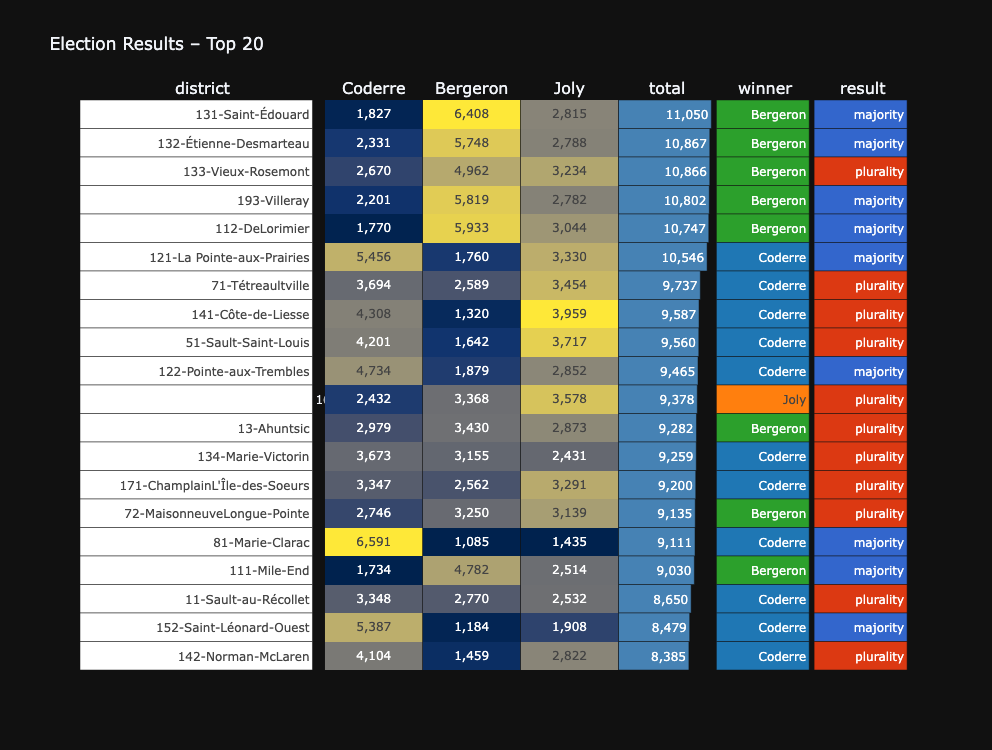

In [ ]:
style_table(
    election.sort_values('total', ascending=False).head(20),
    column_types=['text', 'heatmap', 'heatmap', 'heatmap', 'bar', 'category', 'category'],
    column_widths=[.3, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12 ],
    precision=0,
    theme='plotly_dark',
    title='Election Results – Top 20',
    height=750,
)

## Producing more detailed and readable tables

With large tables and many values, it's good to filter and display the subset that you want, as we do here with the gapminder dataset. We first sort values by `year` and `gdpPercap`, and then get the top five countries for each year. Then we rename the columns to give them a nicer look.

In [ ]:
top5_gdp_percap = (px.data
                   .gapminder()
                   .sort_values(['year', 'gdpPercap'],
                                ascending=[True, False])
                   .groupby('year').head().iloc[:, :-2]
                   [['country', 'continent', 'year', 'gdpPercap', 'lifeExp', 'pop']]
                   .rename(columns={
                       'gdpPercap': 'GDP per capita',
                       'lifeExp': 'Life expectancy',
                       'pop': 'population'}))
top5_gdp_percap.head()


country continent  year  GDP per capita  Life expectancy  \
852          Kuwait      Asia  1952    108382.35290           55.565   
1476    Switzerland    Europe  1952     14734.23275           69.620   
1608  United States  Americas  1952     13990.48208           68.440   
240          Canada  Americas  1952     11367.16112           68.750   
1092    New Zealand   Oceania  1952     10556.57566           69.390   

      population  
852       160000  
1476     4815000  
1608   157553000  
240     14785584  
1092     1994794

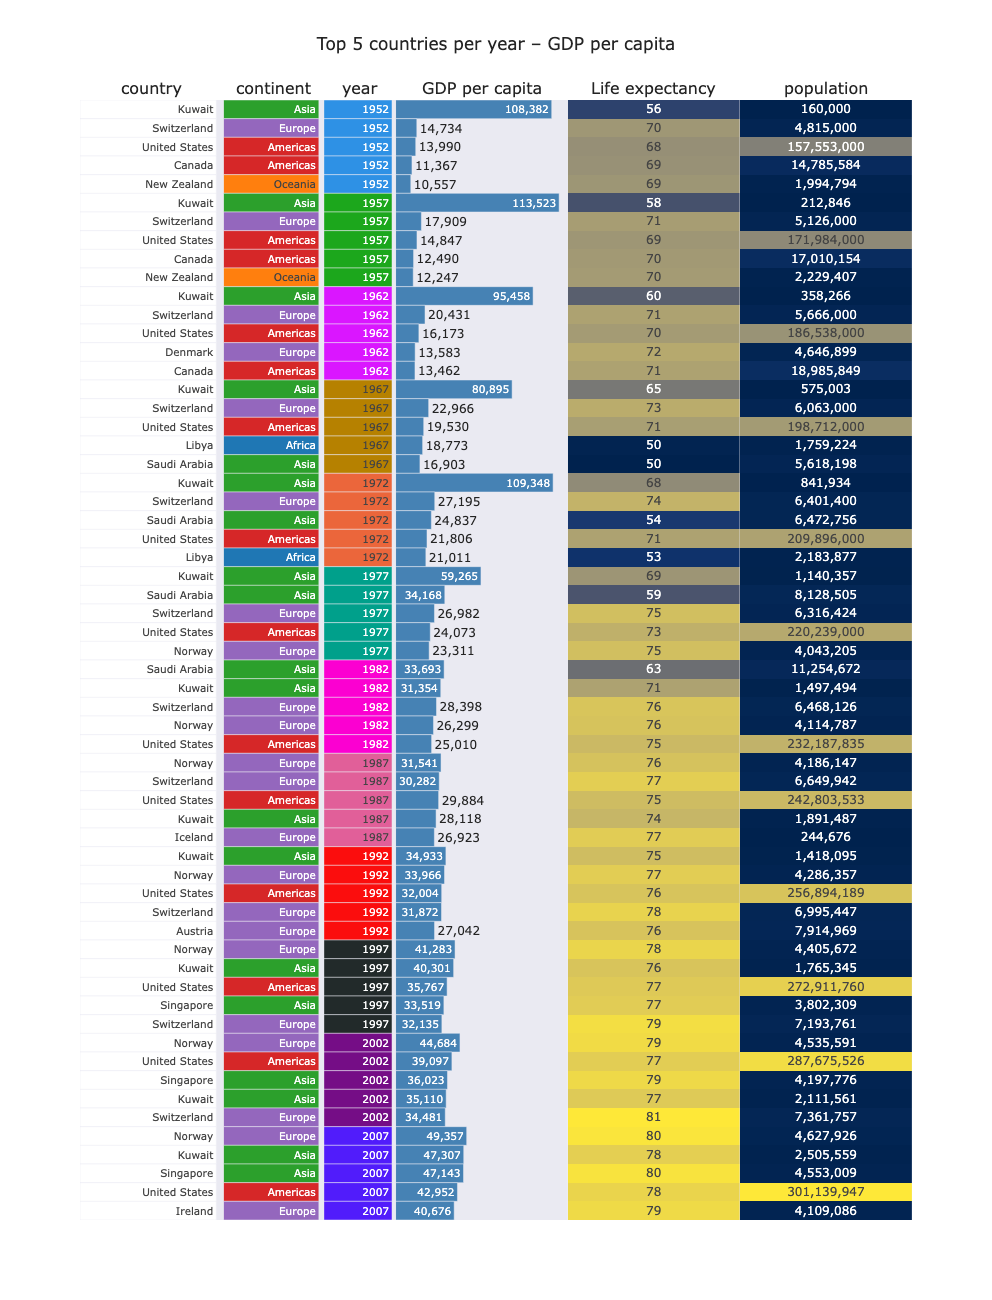

In [ ]:
style_table(
    top5_gdp_percap,
    ['text', 'category', 'category', 'bar', 'heatmap', 'heatmap'],
    column_widths=[.1, .07, .05, .12, .12, .12, ],
    theme='seaborn',
    precision=0,
    title="Top 5 countries per year – GDP per capita",
    height=1300)

## Visualizing hierarchicacal data
See also: the [`adviz.status_codes`](/status_codes.html) chart.

In [ ]:
status_codes = pd.read_csv('data/status_codes.csv')
status_codes['category'] = status_codes['status'].round(-2)
status_codes

status  category
0          200       200
1          200       200
2          200       200
3          200       200
4          200       200
...        ...       ...
414398     200       200
414399     200       200
414400     200       200
414401     200       200
414402     200       200

[414403 rows x 2 columns]

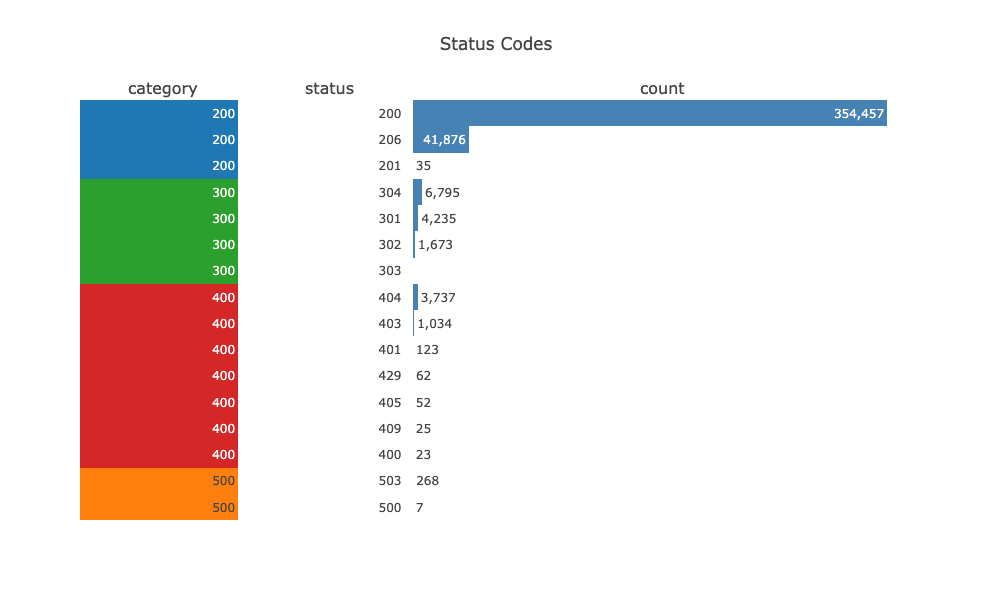

In [ ]:
style_table(
    status_codes[['category', 'status']].value_counts().reset_index().sort_values(['category', 'count'], ascending=[True, False]),
    column_types=['category', 'text', 'bar'],
    column_widths=[.2, .2, .6],
    precision=0,
    theme='none',
    title='Status Codes',
    height=600, width=700)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()